In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/new-york-weather/centralParkWeather.csv
/kaggle/input/nyc-taxi-trip-duration/train.zip
/kaggle/input/nyc-taxi-trip-duration/test.zip
/kaggle/input/nyc-taxi-trip-duration/sample_submission.zip


# Data load

In [2]:
train = pd.read_csv("/kaggle/input/nyc-taxi-trip-duration/train.zip")
test = pd.read_csv("/kaggle/input/nyc-taxi-trip-duration/test.zip")
weather = pd.read_csv("/kaggle/input/new-york-weather/centralParkWeather.csv")

In [3]:
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


# Variable assignment and column drop

In [4]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

In [5]:
# Haversine formula for distance
from math import radians, cos, sin, asin, sqrt

def haversine(row):
    lon1 = row['pickup_longitude']
    lat1 = row['pickup_latitude']
    lon2 = row['dropoff_longitude']
    lat2 = row['dropoff_latitude']
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1 
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    km = 6369 * c
    return km

In [6]:
# Direction formula
def ft_degree(row):
    lon1 = row['pickup_longitude']
    lat1 = row['pickup_latitude']
    lon2 = row['dropoff_longitude']
    lat2 = row['dropoff_latitude']
    km = 6369
    lon_delta_rad = np.radians(lon2 - lon1)
    lat1, lon1, lat2, lon2 = map(np.radians, (lat1, lon1, lat2, lon2))
    y = np.sin(lon_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lon_delta_rad)
    return np.degrees(np.arctan2(y, x))

In [7]:
#Rush Hour Formula
#NYC Rush Hour reference from Staten Island Ferry Schedule
#6am - 10am Morning Rush
#10am - 4pm Day
#4pm - 8pm Evening Rush
#8pm - 6am Night
def rush_hour_f(row):
    rhour = row['real_hour']
    if (6 <= rhour) & (rhour <= 10):
        return 1
    if (10 < rhour) & (rhour < 16):
        return 2
    if (16 <= rhour) & (rhour <= 20):
        return 3
    return 0

In [8]:
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


Train

In [9]:
#Drop outliers
train = train[(train.trip_duration < 1000000)]
train = train[train['pickup_longitude'].between(-75, -73)]
train = train[train['pickup_latitude'].between(40, 42)]
train = train[train['dropoff_longitude'].between(-75, -73)]
train = train[train['dropoff_latitude'].between(40, 42)]
duration = train['trip_duration']
train['trip_duration'] = np.log(train['trip_duration'].values)

In [10]:
#encoding binary categorical
#train = pd.concat([train, pd.get_dummies(train['store_and_fwd_flag'])], axis=1)
#test = pd.concat([test, pd.get_dummies(test['store_and_fwd_flag'])], axis=1)

#train.drop(['store_and_fwd_flag'], axis=1, inplace=True)
#test.drop(['store_and_fwd_flag'], axis=1, inplace=True)

#train = pd.concat([train, pd.get_dummies(train['vendor_id'])], axis=1)
#test = pd.concat([test, pd.get_dummies(test['vendor_id'])], axis=1)

#train.drop(['vendor_id'], axis=1, inplace=True)
#test.drop(['vendor_id'], axis=1, inplace=True)

#no var in test
train.drop(['dropoff_datetime'], axis=1, inplace=True)
train.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,1,-73.982155,40.767937,-73.964630,40.765602,N,6.120297
1,id2377394,1,2016-06-12 00:43:35,1,-73.980415,40.738564,-73.999481,40.731152,N,6.496775
2,id3858529,2,2016-01-19 11:35:24,1,-73.979027,40.763939,-74.005333,40.710087,N,7.661056
3,id3504673,2,2016-04-06 19:32:31,1,-74.010040,40.719971,-74.012268,40.706718,N,6.061457
4,id2181028,2,2016-03-26 13:30:55,1,-73.973053,40.793209,-73.972923,40.782520,N,6.075346


In [11]:
#old
#trainX = train.drop(columns=['id', 'vendor_id','trip_duration'])
#trainY = train[['trip_duration']]

encoder.fit(train['store_and_fwd_flag'])
train['store_and_fwd_flag'] = encoder.transform(train['store_and_fwd_flag'])

train['pickup_datetime'] = pd.to_datetime(train['pickup_datetime'])
train['year'] = train['pickup_datetime'].dt.year
train['month'] = train['pickup_datetime'].dt.month
train['week'] = train['pickup_datetime'].dt.week
train['day'] = train['pickup_datetime'].dt.day


train['weekday'] = train['pickup_datetime'].dt.weekday
train['hour'] = train['pickup_datetime'].dt.hour
train['minute'] = train['pickup_datetime'].dt.minute
train['minute_of_day'] = train['hour'] * 60 + train['minute']
train['real_hour'] = train['minute_of_day'] / 60
#Rush hour formula takes a moment ~30s
train['rush_hour'] = train.apply(rush_hour_f, axis=1)
train['is_weekend'] = train['weekday'] > 4
encoder.fit(train['is_weekend'])
train['is_weekend'] = encoder.transform(train['is_weekend'])

train.drop(['minute'], axis=1, inplace=True)
train.drop(['hour'], axis=1, inplace=True)
train.drop(['pickup_datetime'], axis=1, inplace=True)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  # This is added back by InteractiveShellApp.init_path()


In [12]:
weather.head()

,STATION,NAME,DATE,AWND,PRCP,SNOW,SNWD,TMAX,TMIN
0,USW00094728,"NY CITY CENTRAL PARK, NY US",2009-01-01,11.18,0.0,0.0,0,26,15
1,USW00094728,"NY CITY CENTRAL PARK, NY US",2009-01-02,6.26,0.0,0.0,0,34,23
2,USW00094728,"NY CITY CENTRAL PARK, NY US",2009-01-03,10.07,0.0,0.0,0,38,29
3,USW00094728,"NY CITY CENTRAL PARK, NY US",2009-01-04,7.61,0.0,0.0,0,42,25
4,USW00094728,"NY CITY CENTRAL PARK, NY US",2009-01-05,6.93,0.0,0.0,0,43,38


In [13]:
train.head()

,id,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,year,month,week,day,weekday,minute_of_day,real_hour,rush_hour,is_weekend
0,id2875421,2,1,-73.982155,40.767937,-73.964630,40.765602,0,6.120297,2016,3,11,14,0,1044,17.400000,3,0
1,id2377394,1,1,-73.980415,40.738564,-73.999481,40.731152,0,6.496775,2016,6,23,12,6,43,0.716667,0,1
2,id3858529,2,1,-73.979027,40.763939,-74.005333,40.710087,0,7.661056,2016,1,3,19,1,695,11.583333,2,0
3,id3504673,2,1,-74.010040,40.719971,-74.012268,40.706718,0,6.061457,2016,4,14,6,2,1172,19.533333,3,0
4,id2181028,2,1,-73.973053,40.793209,-73.972923,40.782520,0,6.075346,2016,3,12,26,5,810,13.500000,2,1


In [14]:
train['distance'] = train.apply(haversine, axis=1)
train['direction'] = train.apply(ft_degree, axis=1)
train.head()

,id,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,year,month,week,day,weekday,minute_of_day,real_hour,rush_hour,is_weekend,distance,direction
0,id2875421,2,1,-73.982155,40.767937,-73.964630,40.765602,0,6.120297,2016,3,11,14,0,1044,17.400000,3,0,1.498050,99.970196
1,id2377394,1,1,-73.980415,40.738564,-73.999481,40.731152,0,6.496775,2016,6,23,12,6,43,0.716667,0,1,1.804940,-117.153768
2,id3858529,2,1,-73.979027,40.763939,-74.005333,40.710087,0,7.661056,2016,1,3,19,1,695,11.583333,2,0,6.383094,-159.680165
3,id3504673,2,1,-74.010040,40.719971,-74.012268,40.706718,0,6.061457,2016,4,14,6,2,1172,19.533333,3,0,1.485032,-172.737700
4,id2181028,2,1,-73.973053,40.793209,-73.972923,40.782520,0,6.075346,2016,3,12,26,5,810,13.500000,2,1,1.188215,179.473585


In [15]:
train.head(10)

,id,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,year,month,week,day,weekday,minute_of_day,real_hour,rush_hour,is_weekend,distance,direction
0,id2875421,2,1,-73.982155,40.767937,-73.964630,40.765602,0,6.120297,2016,3,11,14,0,1044,17.400000,3,0,1.498050,99.970196
1,id2377394,1,1,-73.980415,40.738564,-73.999481,40.731152,0,6.496775,2016,6,23,12,6,43,0.716667,0,1,1.804940,-117.153768
2,id3858529,2,1,-73.979027,40.763939,-74.005333,40.710087,0,7.661056,2016,1,3,19,1,695,11.583333,2,0,6.383094,-159.680165
3,id3504673,2,1,-74.010040,40.719971,-74.012268,40.706718,0,6.061457,2016,4,14,6,2,1172,19.533333,3,0,1.485032,-172.737700
4,id2181028,2,1,-73.973053,40.793209,-73.972923,40.782520,0,6.075346,2016,3,12,26,5,810,13.500000,2,1,1.188215,179.473585
5,id0801584,2,6,-73.982857,40.742195,-73.992081,40.749184,0,6.093570,2016,1,4,30,5,1321,22.016667,0,1,1.098597,-44.995596
6,id1813257,1,4,-73.969017,40.757839,-73.957405,40.765896,0,5.831882,2016,6,24,17,4,1354,22.566667,0,0,1.325862,47.505775
7,id1324603,2,1,-73.969276,40.797779,-73.922470,40.760559,0,7.346655,2016,5,20,21,5,474,7.900000,1,1,5.713187,136.385396
8,id1301050,1,1,-73.999481,40.738400,-73.985786,40.732815,0,5.541264,2016,5,21,27,4,1392,23.200000,0,0,1.309942,118.284067
9,id0012891,2,1,-73.981049,40.744339,-73.973000,40.789989,0,7.110696,2016,3,10,10,3,1305,21.750000,0,0,5.119554,7.603538


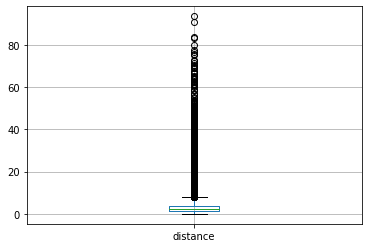

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

train.boxplot(column='distance', return_type='axes');

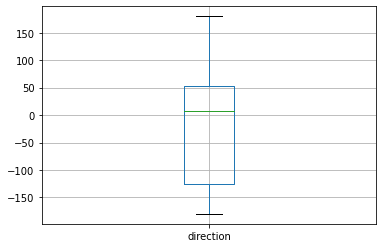

In [17]:
train.boxplot(column='direction', return_type='axes');

In [18]:
#Speed in mph
train['speed'] = train.distance / duration * 2236.936292
train.head()

,id,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,year,...,week,day,weekday,minute_of_day,real_hour,rush_hour,is_weekend,distance,direction,speed
0,id2875421,2,1,-73.982155,40.767937,-73.964630,40.765602,0,6.120297,2016,...,11,14,0,1044,17.400000,3,0,1.498050,99.970196,7.364930
1,id2377394,1,1,-73.980415,40.738564,-73.999481,40.731152,0,6.496775,2016,...,23,12,6,43,0.716667,0,1,1.804940,-117.153768,6.089799
2,id3858529,2,1,-73.979027,40.763939,-74.005333,40.710087,0,7.661056,2016,...,3,19,1,695,11.583333,2,0,6.383094,-159.680165,6.722493
3,id3504673,2,1,-74.010040,40.719971,-74.012268,40.706718,0,6.061457,2016,...,14,6,2,1172,19.533333,3,0,1.485032,-172.737700,7.743408
4,id2181028,2,1,-73.973053,40.793209,-73.972923,40.782520,0,6.075346,2016,...,12,26,5,810,13.500000,2,1,1.188215,179.473585,6.110257


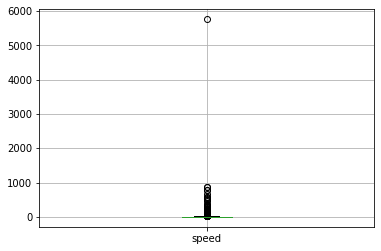

In [19]:
train.boxplot(column='speed', return_type='axes');

In [20]:
#NYS max speed limit 55mph
train = train[(train.speed < 65)]
train.drop(['speed'], axis = 1, inplace=True)

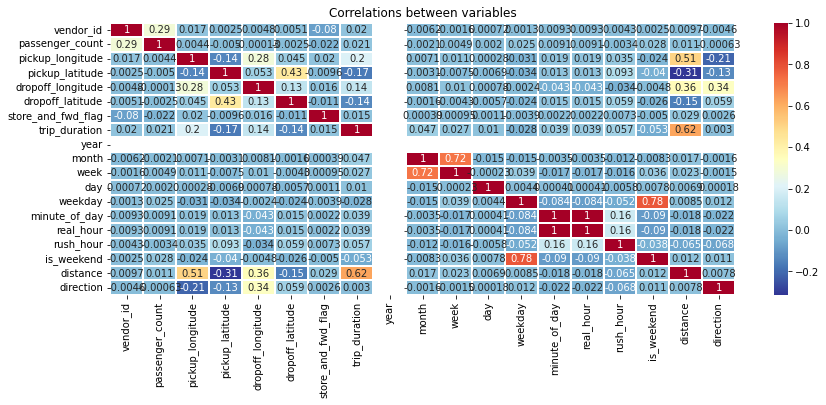

In [21]:
import seaborn as sns
#Correlations between variables
fig, ax = plt.subplots(figsize=(14,5))  
sns.heatmap(data=train.corr(), annot=True, cmap = plt.cm.RdYlBu_r, linewidths=.1, ax=ax).set_title('Correlations between variables');

In [22]:
train.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,year,month,week,day,weekday,minute_of_day,real_hour,rush_hour,is_weekend,distance,direction
count,1.458450e+06,1.458450e+06,1.458450e+06,1.458450e+06,1.458450e+06,1.458450e+06,1.458450e+06,1.458450e+06,1458450.0,1.458450e+06,1.458450e+06,1.458450e+06,1.458450e+06,1.458450e+06,1.458450e+06,1.458450e+06,1.458450e+06,1.458450e+06,1.458450e+06
mean,1.534927e+00,1.664536e+00,-7.397344e+01,4.075095e+01,-7.397335e+01,4.075183e+01,5.515444e-03,6.464861e+00,2016.0,3.516823e+00,1.383985e+01,1.550390e+01,3.050359e+00,8.459848e+02,1.409975e+01,1.397536e+00,2.853516e-01,3.434788e+00,-1.566954e+01
std,4.987787e-01,1.314243e+00,3.842942e-02,2.821502e-02,3.633280e-02,3.247194e-02,7.406098e-02,7.984757e-01,0.0,1.681024e+00,8.564580e+00,8.703143e+00,1.954018e+00,3.843141e+02,6.405235e+00,1.162953e+00,4.515819e-01,3.940675e+00,1.044927e+02
min,1.000000e+00,0.000000e+00,-7.470537e+01,4.022580e+01,-7.477543e+01,4.022580e+01,0.000000e+00,0.000000e+00,2016.0,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.799927e+02
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073589e+01,0.000000e+00,5.983936e+00,2016.0,2.000000e+00,7.000000e+00,8.000000e+00,1.000000e+00,5.730000e+02,9.550000e+00,0.000000e+00,0.000000e+00,1.231611e+00,-1.252773e+02
50%,2.000000e+00,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075453e+01,0.000000e+00,6.495266e+00,2016.0,4.000000e+00,1.300000e+01,1.500000e+01,3.000000e+00,8.860000e+02,1.476667e+01,2.000000e+00,0.000000e+00,2.093147e+00,8.204131e+00
75%,2.000000e+00,2.000000e+00,-7.396734e+01,4.076836e+01,-7.396302e+01,4.076981e+01,0.000000e+00,6.980076e+00,2016.0,5.000000e+00,2.000000e+01,2.300000e+01,5.000000e+00,1.168000e+03,1.946667e+01,2.000000e+00,1.000000e+00,3.873989e+00,5.340521e+01
max,2.000000e+00,9.000000e+00,-7.309228e+01,4.169680e+01,-7.304738e+01,4.169335e+01,1.000000e+00,1.136665e+01,2016.0,6.000000e+00,5.300000e+01,3.100000e+01,6.000000e+00,1.439000e+03,2.398333e+01,3.000000e+00,1.000000e+00,9.346580e+01,1.800000e+02


In [23]:
#extra var: 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 
Y_var = train['trip_duration']
X_var = train.drop(columns=['id', 'trip_duration'])
X_var.head()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,year,month,week,day,weekday,minute_of_day,real_hour,rush_hour,is_weekend,distance,direction
0,2,1,-73.982155,40.767937,-73.964630,40.765602,0,2016,3,11,14,0,1044,17.400000,3,0,1.498050,99.970196
1,1,1,-73.980415,40.738564,-73.999481,40.731152,0,2016,6,23,12,6,43,0.716667,0,1,1.804940,-117.153768
2,2,1,-73.979027,40.763939,-74.005333,40.710087,0,2016,1,3,19,1,695,11.583333,2,0,6.383094,-159.680165
3,2,1,-74.010040,40.719971,-74.012268,40.706718,0,2016,4,14,6,2,1172,19.533333,3,0,1.485032,-172.737700
4,2,1,-73.973053,40.793209,-73.972923,40.782520,0,2016,3,12,26,5,810,13.500000,2,1,1.188215,179.473585


Test

In [24]:
test.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,N
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,N
2,id1217141,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,N
3,id2150126,2,2016-06-30 23:59:41,1,-73.956070,40.771900,-73.986427,40.730469,N
4,id1598245,1,2016-06-30 23:59:33,1,-73.970215,40.761475,-73.961510,40.755890,N


In [25]:
#old
#testX = test.drop(columns=['id','vendor_id'])
#testY = test[['id']]

encoder.fit(test['store_and_fwd_flag'])
test['store_and_fwd_flag'] = encoder.transform(test['store_and_fwd_flag'])

test['pickup_datetime'] = pd.to_datetime(test['pickup_datetime'])
test['year'] = test['pickup_datetime'].dt.year

test['month'] = test['pickup_datetime'].dt.month
test['week'] = test['pickup_datetime'].dt.week
test['weekday'] = test['pickup_datetime'].dt.weekday
test['day'] = test['pickup_datetime'].dt.day

test['hour'] = test['pickup_datetime'].dt.hour
test['minute'] = test['pickup_datetime'].dt.minute
test['minute_of_day'] = test['hour'] * 60 + test['minute']
test['real_hour'] = test['minute_of_day'] / 60
#Rush hour formula takes a moment ~30s
test['rush_hour'] = test.apply(rush_hour_f, axis=1)
test['is_weekend'] = test['weekday'] > 4
encoder.fit(test['is_weekend'])
test['is_weekend'] = encoder.transform(test['is_weekend'])



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  if sys.path[0] == '':


In [26]:
weather["DATE"] = pd.to_datetime(weather["DATE"])
weather['year'] = weather['DATE'].dt.year
weather_2016 = weather[weather["year"]== 2016]
weather_2016.drop(['STATION',"NAME","year"], axis =1, inplace = True)
train['DATE']=pd.to_datetime(train[['year','month','day']],errors='coerce')
test['DATE']=pd.to_datetime(test[['year','month','day']],errors='coerce')

left_merge = pd.merge(left=train, right = weather_2016, on = "DATE", how="left")
left_merge_test = pd.merge(left=test, right = weather_2016, on = "DATE", how="left")
train = left_merge.loc[:, left_merge.columns != 'DATE']
test = left_merge_test.loc[:, left_merge_test.columns != 'DATE']

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [27]:
test.drop(['minute'], axis=1, inplace=True)
test.drop(['hour'], axis=1, inplace=True)
test.drop(['pickup_datetime'], axis=1, inplace=True)

In [28]:
#Haversine and direction formula takes a moment ~130s
test['distance'] = test.apply(haversine, axis=1)
test['direction'] = test.apply(ft_degree, axis=1)
test.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,id,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,year,month,...,rush_hour,is_weekend,AWND,PRCP,SNOW,SNWD,TMAX,TMIN,distance,direction
0,id3004672,1,1,-73.988129,40.732029,-73.990173,40.756680,0,2016,6,...,0,0,2.91,0.0,0.0,0,85,67,2.745564,-3.595224
1,id3505355,1,1,-73.964203,40.679993,-73.959808,40.655403,0,2016,6,...,0,0,2.91,0.0,0.0,0,85,67,2.758373,172.278835
2,id1217141,1,1,-73.997437,40.737583,-73.986160,40.729523,0,2016,6,...,0,0,2.91,0.0,0.0,0,85,67,1.305745,133.326248
3,id2150126,2,1,-73.956070,40.771900,-73.986427,40.730469,0,2016,6,...,0,0,2.91,0.0,0.0,0,85,67,5.267434,-150.956833
4,id1598245,1,1,-73.970215,40.761475,-73.961510,40.755890,0,2016,6,...,0,0,2.91,0.0,0.0,0,85,67,0.960540,130.260381


In [29]:
#extra var: , 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude'
X_var_test = test.drop(columns=['id'])

In [30]:
X_var_test.shape

(625134, 24)

In [31]:
train.head()

,id,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,year,...,rush_hour,is_weekend,distance,direction,AWND,PRCP,SNOW,SNWD,TMAX,TMIN
0,id2875421,2,1,-73.982155,40.767937,-73.964630,40.765602,0,6.120297,2016,...,3,0,1.498050,99.970196,14.09,0.29,0.0,0,51,40
1,id2377394,1,1,-73.980415,40.738564,-73.999481,40.731152,0,6.496775,2016,...,0,1,1.804940,-117.153768,8.05,0.00,0.0,0,83,62
2,id3858529,2,1,-73.979027,40.763939,-74.005333,40.710087,0,7.661056,2016,...,2,0,6.383094,-159.680165,10.96,0.00,0.0,0,28,16
3,id3504673,2,1,-74.010040,40.719971,-74.012268,40.706718,0,6.061457,2016,...,3,0,1.485032,-172.737700,6.04,0.00,0.0,0,48,30
4,id2181028,2,1,-73.973053,40.793209,-73.972923,40.782520,0,6.075346,2016,...,2,1,1.188215,179.473585,6.49,0.00,0.0,0,55,38


In [32]:
train["good_weather"] = ((train['PRCP'] == 0) & (train['SNOW'] == 0))

In [33]:
train.drop(['AWND', 'PRCP', 'SNOW'], axis=1, inplace=True)

In [34]:
test["good_weather"] = ((test['PRCP'] == 0) & (test['SNOW'] == 0))
test.drop(['AWND', 'PRCP', 'SNOW'], axis=1, inplace=True)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [35]:
test["t_mean"] = ((test['TMAX']) + (test['TMIN']))/ 2
test.drop(['TMAX', 'TMIN'], axis=1, inplace=True)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [36]:
train["t_mean"] = ((train['TMAX']) + (train['TMIN']))/ 2
train.drop(['TMAX', 'TMIN'], axis=1, inplace=True)

In [37]:

encoder.fit(train['store_and_fwd_flag'])
train['good_weather'] = encoder.transform(train['good_weather'])
test['good_weather'] = encoder.transform(test['good_weather'])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [38]:
train['rush_hour'].unique()

array([3, 0, 2, 1])

In [39]:
from sklearn.model_selection import train_test_split

trainXsplit, testXsplit, trainYsplit, testYsplit = train_test_split(X_var, Y_var, test_size=625134, random_state=42)
trainXsplit.shape, trainYsplit.shape, testXsplit.shape, testYsplit.shape

((833316, 18), (833316,), (625134, 18), (625134,))

# Model LightGBM

In [40]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1458450 entries, 0 to 1458449
Data columns (total 23 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458450 non-null  object 
 1   vendor_id           1458450 non-null  int64  
 2   passenger_count     1458450 non-null  int64  
 3   pickup_longitude    1458450 non-null  float64
 4   pickup_latitude     1458450 non-null  float64
 5   dropoff_longitude   1458450 non-null  float64
 6   dropoff_latitude    1458450 non-null  float64
 7   store_and_fwd_flag  1458450 non-null  int64  
 8   trip_duration       1458450 non-null  float64
 9   year                1458450 non-null  int64  
 10  month               1458450 non-null  int64  
 11  week                1458450 non-null  int64  
 12  day                 1458450 non-null  int64  
 13  weekday             1458450 non-null  int64  
 14  minute_of_day       1458450 non-null  int64  
 15  real_hour      

In [41]:
#~250s
from sklearn.metrics import mean_squared_error as MSE
import lightgbm as lgb

lgb_params = {
    #'metric' : 'rmse',
    'learning_rate': 0.1,
    'max_depth': 25,
    'num_leaves': 1000, 
    'objective': 'regression',
    'feature_fraction': 0.9,
    'bagging_fraction': 0.5,
    'max_bin': 1000 }

#Training on all labeled data using the best parameters
lgb_df = lgb.Dataset(X_var, Y_var)
#lgb_df = lgb.Dataset(trainXsplit, trainYsplit)
lgb_model = lgb.train(lgb_params, lgb_df, num_boost_round=1500)

#modelX.fit(trainXsplit, trainYsplit, verbose=True)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.107942 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7945
[LightGBM] [Info] Number of data points in the train set: 1458450, number of used features: 17
[LightGBM] [Info] Start training from score 6.464861


In [42]:
#~60s
test_col = X_var.columns
#y_pred = np.exp(lgb_model.predict(test[test_col]))
y_pred = lgb_model.predict(X_var_test[test_col])

# Submission

In [43]:
submission = pd.DataFrame({'id': test.id, 'trip_duration': np.exp(y_pred)})
submission.to_csv('submission.csv', index=False)
submission.head()

,id,trip_duration
0,id3004672,678.725844
1,id3505355,626.499303
2,id1217141,380.292504
3,id2150126,973.996711
4,id1598245,446.685854


In [44]:
submission.shape

(625134, 2)

# Visualization and accuracy

In [45]:
#from sklearn.metrics import accuracy_score
#modelX.score(X_var, Y_var)

# Sources
Tutorials
* https://python-visualization.github.io/folium/quickstart.html
* https://www.kaggle.com/dcstang/create-table-of-contents-in-a-notebook#Introduction
* https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop_duplicates.html
* https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html
* https://pandas.pydata.org/docs/reference/api/pandas.Series.between.html
* https://stackoverflow.com/questions/32980087/pandas-not-in-in-and-between
* https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.loc.html
* https://stackoverflow.com/questions/53872905/iterate-over-first-n-rows-in-pandas

Notebooks and reference
* https://www.kaggle.com/c/nyc-taxi-trip-duration/data
* https://www.kaggle.com/alexisbcook/manipulating-geospatial-data
* https://www.kaggle.com/camnugent/geospatial-feature-engineering-and-visualization
* https://www.kaggle.com/quentinmonmousseau/ml-workflow-lightgbm-0-37-randomforest-0-39
* https://www.kaggle.com/brianfong192/predicting-trip-durations-with-xgboost-lb-0-433?scriptVersionId=1509647
* https://www.gps-coordinates.net/
* https://www.siferry.com/schedules.html


Extra
* https://www.sheknows.com/living/articles/1126288/man-get-hit-nyc-taxi-playing-pokemon-go/
* https://abcnews.go.com/Travel/ny-la-taxi-ride-friends-celebrating-birthday/story?id=13452198